In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Import Raw Data

In [112]:
clx = pd.read_csv("../PSData/Clx18.csv", skiprows=3)
pop = pd.read_csv("../PSData/Pops18.csv", skiprows=3)
smr = pd.read_csv("../PSData/Summer18.csv", skiprows=3)
spc = pd.read_csv("../PSData/Specials16-18.csv", skiprows=3)
oth = pd.concat([
    pd.read_csv("../PSData/Chamber16-18.csv", skiprows=3),
    pd.read_csv("../PSData/Connections16-18.csv", skiprows=3),
    pd.read_csv("../PSData/Organ16-18.csv", skiprows=3)
], ignore_index=True)

In [113]:
clx.insert(0, "series", "clx")
pop.insert(0, "series", "pop")
smr.insert(0, "series", "smr")
spc.insert(0, "series", "spc")
oth.insert(0, "series", "oth")

In [162]:
df_raw = pd.concat([clx, pop, smr, spc, oth], ignore_index=True)

In [163]:
df_raw.dtypes

series                  object
perf_code               object
perf_no                  int64
perf_dt                 object
zone_no                  int64
zone_desc               object
section                 object
row                     object
seat                     int64
home_price             float64
paid_amt               float64
fee_amt                float64
seat_status              int64
seat_status_desc        object
customer_no            float64
order_no               float64
order_dt                object
price_type_group_id    float64
price_type_group        object
pd_up                   object
season                   int64
season_desc             object
summary_cust_id        float64
summary_cust_name       object
attended                object
dtype: object

In [164]:
df_raw.head()

,series,perf_code,perf_no,perf_dt,zone_no,zone_desc,section,row,seat,home_price,...,order_no,order_dt,price_type_group_id,price_type_group,pd_up,season,season_desc,summary_cust_id,summary_cust_name,attended
0,clx,PS091417,15737,9/14/2017 8:00:00 PM,4168,Price 3 Accessible Orchestra,ORCH T,ZZ,121,66.00,...,0.0,NaN,NaN,NaN,AVL,542,PS 17-18 Classics,NaN,NaN,NaN
1,clx,PS091417,15737,9/14/2017 8:00:00 PM,4160,Price 1 Orchestra Terrace Left,ORCH T,Y,3,116.00,...,NaN,NaN,NaN,NaN,AVL,542,PS 17-18 Classics,NaN,NaN,NaN
2,clx,PS091417,15737,9/14/2017 8:00:00 PM,4181,Price 4 Orchestra,ORCH,D,126,24.25,...,NaN,NaN,1.0,Subscription,PD,542,PS 17-18 Classics,NaN,NaN,NaN
3,clx,PS091417,15737,9/14/2017 8:00:00 PM,4168,Price 3 Accessible Orchestra,ORCH T,ZZ,122,66.00,...,0.0,NaN,NaN,NaN,AVL,542,PS 17-18 Classics,NaN,NaN,NaN
4,clx,PS091417,15737,9/14/2017 8:00:00 PM,4159,Price 1 Orchestra Terr Center,ORCH T,T,104,116.00,...,NaN,NaN,NaN,NaN,AVL,542,PS 17-18 Classics,NaN,NaN,NaN


## Create copy of Raw data

In [283]:
df_cust = df_raw[df_raw.summary_cust_id > 0].reset_index()

In [284]:
df_cust.head()

,index,series,perf_code,perf_no,perf_dt,zone_no,zone_desc,section,row,seat,...,order_no,order_dt,price_type_group_id,price_type_group,pd_up,season,season_desc,summary_cust_id,summary_cust_name,attended
0,188,clx,PS091417,15737,9/14/2017 8:00:00 PM,4184,Price 5 Orchestra,ORCH,B,121,...,5782795.0,3/6/2017 12:00:00 AM,1.0,Subscription,PD,542,PS 17-18 Classics,13241.0,Rosalind Britton Household,NaN
1,189,clx,PS091417,15737,9/14/2017 8:00:00 PM,4184,Price 5 Orchestra,ORCH,B,122,...,5782795.0,3/6/2017 12:00:00 AM,1.0,Subscription,PD,542,PS 17-18 Classics,13241.0,Rosalind Britton Household,Attended
2,190,clx,PS091417,15737,9/14/2017 8:00:00 PM,4158,Price 1 Orchestra,ORCH,D,110,...,5782797.0,3/24/2017 12:00:00 AM,1.0,Subscription,PD,542,PS 17-18 Classics,18631.0,Ms. Hani Feller,Attended
3,191,clx,PS091417,15737,9/14/2017 8:00:00 PM,4181,Price 4 Orchestra,ORCH,E,128,...,5782798.0,3/24/2017 12:00:00 AM,1.0,Subscription,PD,542,PS 17-18 Classics,21418.0,Ms. Debra J. Hali,Attended
4,192,clx,PS091417,15737,9/14/2017 8:00:00 PM,4182,Price 4 Orchestra Terrace,ORCH T,V,32,...,5869002.0,3/24/2017 5:03:53 PM,8.0,Flex,PD,542,PS 17-18 Classics,26400.0,Michael Lawler,Attended


## Assign Dummy Vars

In [285]:
df_cust = df_cust.assign(sub=lambda df: [1 if (grp == "Subscription" or grp == "Flex") else 0 for grp in df.price_type_group])

In [286]:
df_cust = df_cust.assign(attended=lambda df: [1 if attended == "Attended" else 0 for attended in df.attended])

In [287]:
df_cust = pd.concat([df_cust, pd.get_dummies(df_cust.series)], axis=1)

## Isolate columns

In [288]:
cols = ['summary_cust_id', 'clx', 'pop', 'smr', 'spc', 'oth',
        'attended', 'sub', 'paid_amt']

In [345]:
df_cust_formatted = df_cust.loc[:, cols]

## Group by ID

In [387]:
aggregator = {
    'clx': 'sum',
    'pop': 'sum',
    'smr': 'sum',
    'spc': 'sum',
    'oth': 'sum',
    'sub': 'sum',
    'attended': 'sum',
    'paid_amt': 'sum',
}

df_cust_grouped = df_cust_formatted.groupby('summary_cust_id', as_index=False).agg(aggregator)

In [388]:
# Set the index
df_cust_grouped = df_cust_grouped.set_index('summary_cust_id')

In [389]:
df_cust_grouped = df_cust_grouped.assign(total_tix=lambda x: df_cust_grouped['clx'] + df_cust_grouped['pop'] + df_cust_grouped['smr'] + df_cust_grouped['spc'] + df_cust_grouped['oth'],
                  attended_perc=lambda x: df_cust_grouped['attended'] / (df_cust_grouped['clx'] + df_cust_grouped['pop'] + df_cust_grouped['smr'] + df_cust_grouped['spc'] + df_cust_grouped['oth']))

df_cust_grouped.head()

,clx,pop,smr,spc,oth,sub,attended,paid_amt,total_tix,attended_perc
summary_cust_id,,,,,,,,,,
10161.0,12.0,0.0,0.0,2.0,0.0,12,14,1214.0,14.0,1.000000
10327.0,8.0,0.0,0.0,0.0,2.0,10,10,375.0,10.0,1.000000
11900.0,2.0,0.0,0.0,2.0,2.0,0,4,532.0,6.0,0.666667
12501.0,0.0,4.0,0.0,0.0,0.0,0,4,200.0,4.0,1.000000
12916.0,0.0,0.0,0.0,0.0,2.0,0,0,112.0,2.0,0.000000


## Import Donor Data

In [390]:
donor = pd.read_csv("../PSData/enhanced_fund_fy15-present.csv", encoding='ISO-8859-1')

In [391]:
donor_aggregator = {
    'gift_plus_pledge': 'sum'
}

donor = donor.groupby('summary_cust_id', as_index=False).agg(donor_aggregator)
donor = donor.set_index('summary_cust_id')

## Merge donor data with ticket data

In [392]:
tx_dnr_combo = pd.concat([df_cust_grouped, donor], axis=1).fillna(0)

In [393]:
combo_copy = tx_dnr_combo.copy()

## Remove Outliers from Dataset

In [394]:
from scipy import stats
combo_copy = combo_copy[(np.abs(stats.zscore(combo_copy)) < 3).all(axis=1)]

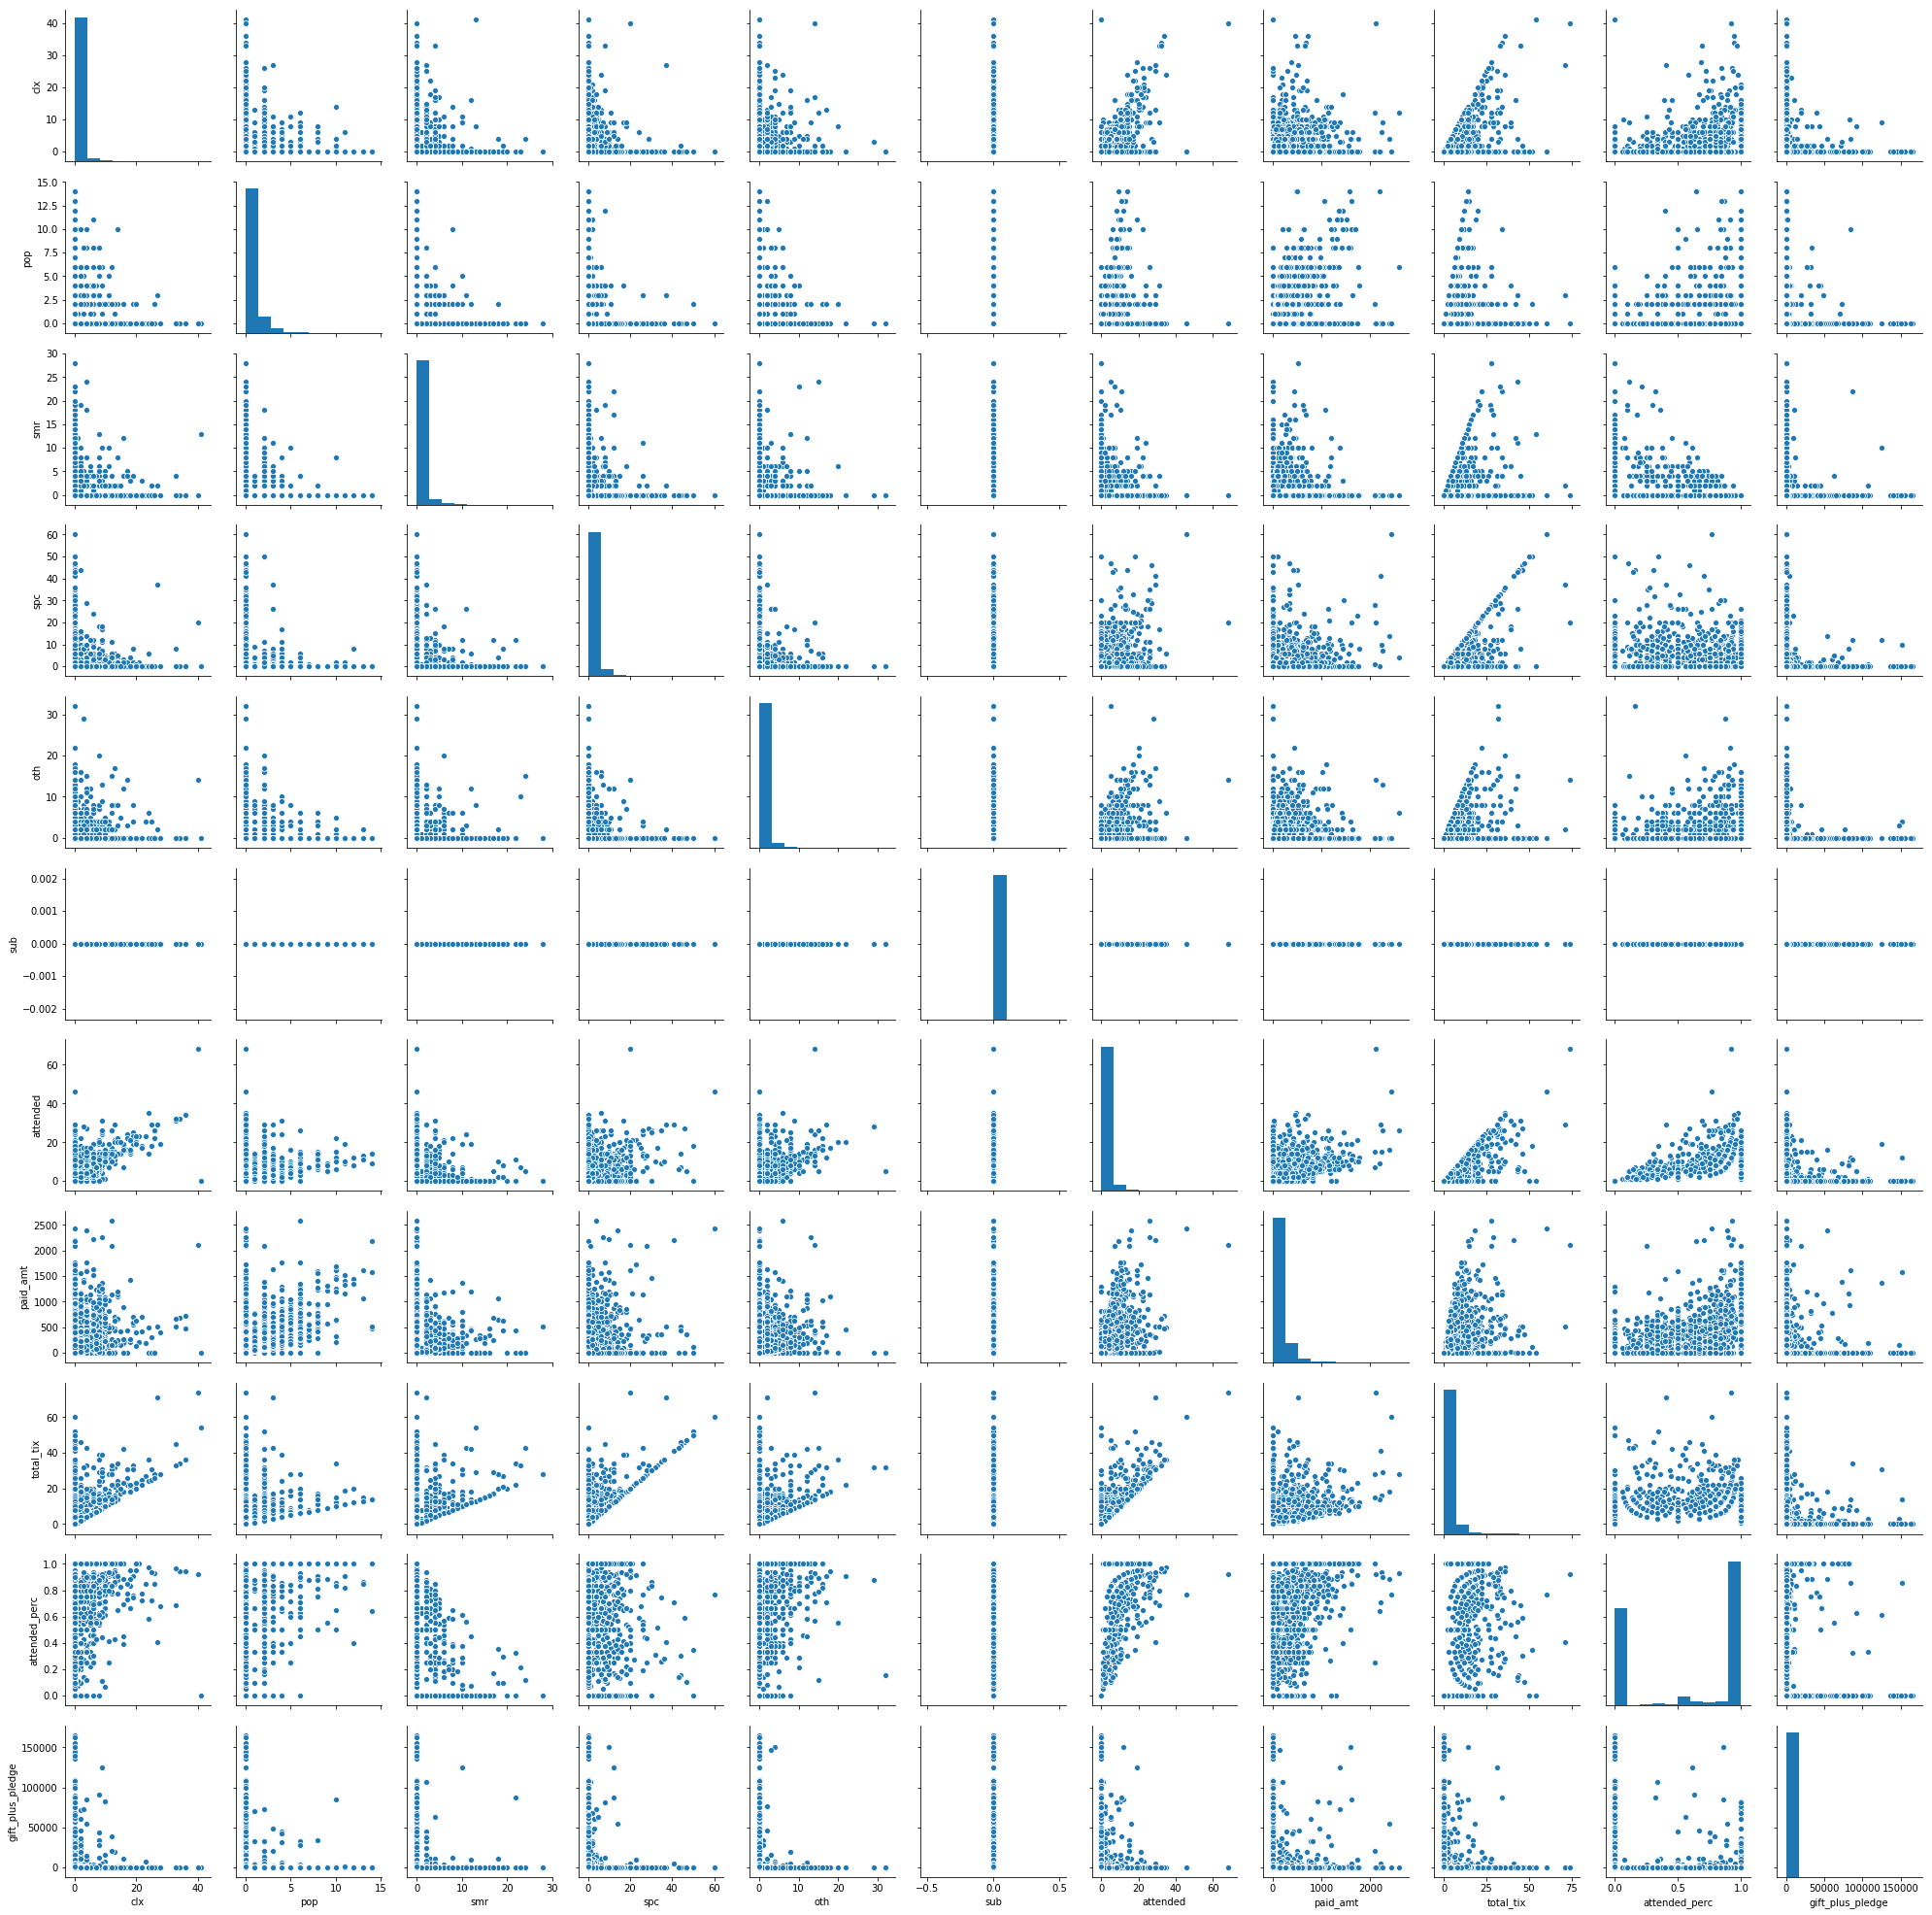

In [399]:
sns.pairplot(combo_copy.loc[combo_copy["sub"] == 0])